In [14]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde

In [15]:
# check if the gpu is available or not, if yes, use gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
args = {
    "likelihood": "laplace", # specify the likelihood distribution,p(x|z)
    "adjoint": True, # specify whether to use adjoint sensitivty method to backward the sde
    "debug": True, # specify whether to debug or not
    "data": "segmented_cosine",# specify which data to use
    "kl_anneal_iters": 100, # number of the iterations of the annealing kl divergence schedule
    "train_iters": 1000, # number of iterations to train the model
    "batch_size": 100, 
    "adaptive": False, # whether use adaptive solver or not
    "method": "euler", # the method of sde solver
    "dt": 1e-2, # the parameter dt of sde solver
    "rtol": 1e-3, # the parameter rtol of sde solver
    "atol": 1e-3, # the atol of sde solver
    "scale": 0.05, # the scale, of the likelihood distribution
    "dpi": 500, # dpi of images
    "pause_iters": 50 # the interval to evaluate the model
}

In [17]:
# w/ underscore -> numpy; w/o underscore -> torch.
'''
    ts: original time series; can be segmented or irregular
    ts_ext: with extended time outisde the time series, use to generate latent outside to penalize out-of-data region and spread uncertainty
    ts_vis: regular time series used to plot the data
    ys: the observed dynamic, same size as ts
'''

Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])

In [18]:
class LinearScheduler(object):
    '''
        output a value follows linear schedule from maxval/iters to maxval, with 'iters' steps
    '''
    
    '''
        iters = 100,
        maxval = 1,
        1/100 = 0.001, 0.002, .... 1
    '''
    
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val

In [19]:
class EMAMetric(object):
    '''
        Exponential moving average, used to calculate the average
    '''
    def __init__(self, gamma: Optional[float] = .99):
        super(EMAMetric, self).__init__()
        self._val = 0.
        self._gamma = gamma

    def step(self, x: Union[torch.Tensor, np.ndarray]):
        x = x.detach().cpu().numpy() if torch.is_tensor(x) else x
        self._val = self._gamma * self._val + (1 - self._gamma) * x
        return self._val

    @property
    def val(self):
        return self._val

In [20]:
def manual_seed(seed: int):
    '''
        set the random seed, make sure the result keeps the same for each call
    '''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [21]:
def _stable_division(a, b, epsilon=1e-7): #a/b
    '''
        change all elements x in b s.t -epsilon < x < epsilon to epsilon, to make sure the division is stable, won't cause a really large number
    '''
    
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b

In [54]:
class LatentSDE(torchsde.SDEIto):

    def __init__(self,theta=1.0,mu=[0.0,0.0], sigma=[0.5,0.5]):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        # logvar = math.log(sigma ** 2 / (2. * theta)) # calculate the log variance
        # Prior drift.
        
        var = [t**2/(2.*theta) for t in sigma]
        
        self.register_buffer("theta", torch.tensor([[theta]])) # prior parameters, register 成buffer, 参数不会进行更新
        self.register_buffer("mu", torch.tensor(mu))
        self.register_buffer("sigma", torch.tensor(sigma)) 

        # p(z0).
        self.register_buffer("py0_mean", torch.tensor(mu)) 
        
        self.register_buffer("py0_var",torch.tensor(var))

        # Approximate posterior drift: Takes in 2 positional encodings and the state. f(t,y)
        self.net = nn.Sequential( #h\Phi()
            nn.Linear(self.mu.size(0)+2, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, self.mu.size(0))
        )
        # Initialization trick from Glow. 
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0). the initial value of the approx posterior distribution
        self.qy0_mean = nn.Parameter(torch.tensor(mu), requires_grad=True) 
        self.qy0_var = nn.Parameter(torch.tensor(var), requires_grad=True)

    def f(self, t, y):  # Approximate posterior drift. f(t, y) = t # h\Phi
        if t.dim() == 0:
            #t = torch.full_like(y, fill_value=t)
            t = t.repeat(y.size(0),1).to(device)
        # Positional encoding in transformers for time-inhomogeneous posterior.
        #print(y.size())
        #print(t.size())
        #print(torch.cat((torch.sin(t),torch.cos(t),y),dim=-1).size())
        res = self.net(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))
        #print(res.size())
        return res
    def g(self, t, y):  # Shared diffusion. g(t,y) = sigma
        return self.sigma.repeat(y.size(0), 1) # should chage to 2, since we have two dimension latent variable

    def h(self, t, y):  # Prior drift. h(t,y) = theta * y
        #return y.view(y.size(0),1)*self.theta # need to figure out
        h = self.theta*(self.mu-y)    
        return h
    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        '''
             y has two columns, the first column is y0, the one we want to generate the SDE dynamic
             the second column is 0, used to generate the sampling paths from the posterior process, and used to estimate the kl divergence
        '''
        y = y[:, 0:self.mu.size(0)] # get the first column of y, that is to get y0 # z0
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y) # calculate f, g, h
        u = _stable_division(f - h, g) # u(z,t) = (f-h)/g
        #print("f_aug",u.size())
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True) # (u^2)/2, the drift of the second sde
        #print("f_aug",y.size())
        #print("f_aug",torch.cat([f,f_logqp],dim=1).size())
        return torch.cat([f, f_logqp], dim=1) # [batch_size, 2]

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:self.mu.size(0)]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y[:,0:1]) # the diffusion of the second sde
        #print("g_aug",y.size())
        #print("g_aug",torch.cat([g,g_logqp],dim=1).size())
        return torch.cat([g, g_logqp], dim=1) # [batch_size, 2]

    def forward(self, ts, batch_size, eps=None):
        # recognition process
        #eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        #y0 = self.qy0_mean + eps * self.qy0_std # randomly generate z0 from approx posterior distribution q(z|x)
        
        y = distributions.multivariate_normal.MultivariateNormal(self.qy0_mean,torch.diag(self.qy0_var))
        y0 = y.rsample([batch_size])
        #print("a",y0.size()) # [batch_size, 2]
                 
        #qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std) # approx posterior distribution
        #py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std) # prior distribution
        
        qy0 = distributions.multivariate_normal.MultivariateNormal(loc=self.qy0_mean, covariance_matrix=torch.diag(self.qy0_var))
        py0 = distributions.multivariate_normal.MultivariateNormal(loc=self.py0_mean, covariance_matrix=torch.diag(self.py0_var))
        
        logqp0 = distributions.kl_divergence(qy0, py0)  # KL(t=0). # kl divergence when t = 0
        logqp0 = logqp0.view(1,)
        
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        #print("b",aug_y0.size())
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts, #[0,0.1,0.2, 0.3]
            method=args["method"],
            dt=args["dt"],
            adaptive=args["adaptive"],
            rtol=args["rtol"],
            atol=args["atol"],
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        #[len(ts),batch_size,2]
        ys, logqp_path = aug_ys[:, :, 0:self.mu.size(0)], aug_ys[-1, :, self.mu.size(0)] 
        # the first column of the last dimension is the sample dynamic
        # the second column of the last dimension is the kl divergence
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path). # calculate the kl divergence
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        '''
            latent variable samples from prior distribution p(z), and their SDE dynamics
        '''
        #eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        #y0 = self.py0_mean + eps * self.py0_std # [batch_size, 1]: [1024, 1]
                 
        y = distributions.multivariate_normal.MultivariateNormal(self.py0_mean,torch.diag(self.py0_var))
        y0 = y.rsample([batch_size])
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args["dt"], names={'drift': 'h'}) # [len(ts), batch_size, 1]: [300, 1024,1]
        return yt

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        '''
            latent variable samples from approx posterior distribution q(z|x), and their SDE dynamics
        '''
        #eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        #y0 = self.qy0_mean + eps * self.qy0_std # [batch_size, 1]: [1024, 1]
                 
        y = distributions.multivariate_normal.MultivariateNormal(self.qy0_mean,torch.diag(self.qy0_var))
        y0 = y.rsample([batch_size])
                 
        return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args["dt"]) # [len(ts), batch_size, 1]: [300, 1024, 1]


    



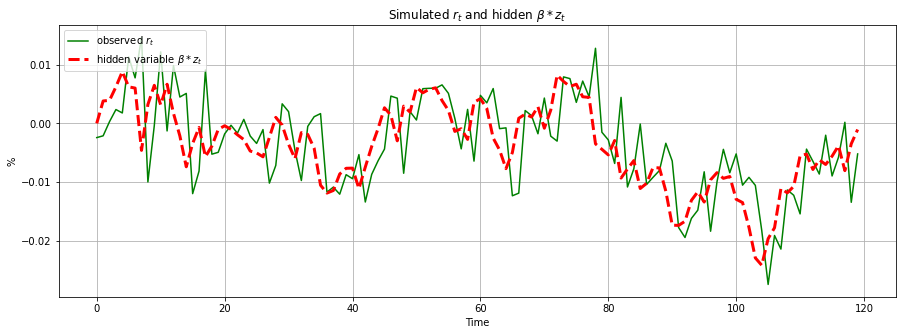

In [84]:
T = 120
#beta = 0.1694
beta=1
phi = 0.9
sigma_v = 0.003342
sigma_u = 0.00496
mu = 0
def make_time_series():
    
    
    noise_mu = [0, 0]
    sigma_u = u_over_v * sigma_v
    cov_uv = rho*sigma_u*sigma_v
    cov = [[sigma_u**2, cov_uv], [cov_uv, sigma_v**2]]
    
    shocks = np.random.multivariate_normal(noise_mu, cov, T) # 1st column is u; 2nd columne is v
    z0 = np.random.normal(mu, sigma_u ** 2/(1-phi**2), 1)
    r0 = shocks[0][0]

    z = np.zeros(T)
    r = np.zeros(T)
    z[0] = z0
    r[0] = r0

    for idx_t in range(T-1):
        z[idx_t+1] = phi*(z[idx_t]-mu) + shocks[idx_t+1][1] + mu
        r[idx_t+1] = beta*z[idx_t] + shocks[idx_t+1][0]
    return r, z
r,z = make_time_series()
plt.figure(figsize=(15,5))
xvalues = np.array(range(T))
plt.plot(xvalues, r, linestyle='-', color='g', label="observed $r_t$")
plt.plot(xvalues, z, linestyle="--", color="r", label=r"hidden variable $\beta * z_t$", linewidth=3.0)

plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('%')
plt.grid(True)
plt.title(r"Simulated $r_t$ and hidden $\beta * z_t$")
plt.show()

In [85]:
def make_data():
    ts_ = np.linspace(0.1,3.0,120)
    ts_ext_ = np.array([0.] + list(ts_) + [3.1])
    ts_vis_ = np.linspace(0.1, 3.1, 121)
    ys_ = r[:,None]
    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)  

In [86]:
def main():
    # Dataset.
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()

    beta = torch.tensor([0,0.2,0.8,1.4])
    mu = torch.ones(beta.size(0)-1)*torch.mean(ys)
    sigma = torch.ones(beta.size(0)-1)*torch.std(ys)
    
    # Plotting parameters.
    vis_batch_size = 1024 # the batch_size used to visaulize
    ylims = (-1.75, 1.75) # set up the ylim of the figure
    
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    
    vis_idx = np.random.permutation(vis_batch_size) # shuffle the numbers from 1-vis_batch_size
    # From https://colorbrewer2.org/.

    sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026') 
    fill_color = '#fd8d3c'
    
    mean1_color = '#800026'
    mean2_color = '#fc4e2a'
    expected_color = '#e31a1c'
    
    num_samples = len(sample_colors)
    
    # eps = torch.randn(vis_batch_size, 1).to(device)  # samples from normal distribution
    
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size, beta.size(0)-1),
        device=device,
        levy_area_approximation='space-time'
    )  # We need space-time Levy area to use the SRK solver, fix the brownian motion allows us to generate the sde dynamic fexedly

    # Model.
    model = LatentSDE(mu=mu,sigma=sigma).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    kl_scheduler = LinearScheduler(iters=args["kl_anneal_iters"])

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()
    
    with torch.no_grad():
        zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, bm=bm).squeeze() # sde dynamic sampled from prior distribution
        #zs = 0.5*zs[:,:,0]+0.5*zs[:,:,1]
        zs = torch.cat((torch.ones((zs.size(0),zs.size(1),1)),zs),dim=-1)
        zs = torch.matmul(zs, beta)
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()  # convert them to numpy
        # print(zs.size()) # [len(ts_vis), batch_size]: [300, 1024]
        
        zs_ = np.sort(zs_, axis=1) # sort each row

        img_dir = os.path.join('./img_multiple_dims/' 'prior.png')
        plt.subplot(frameon=False)
        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size) # 选择要考虑百分之多少的数据
            zs_bot_ = zs_[:, idx] # 计算底线
            zs_top_ = zs_[:, -idx] # 计算顶线
            plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color) # 用来填充两条曲线之间的区域
        # `zorder` determines who's on top; the larger the more at the top.
        plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # scatter plot the original observed dynamic
        plt.ylim(ylims) 
        plt.xlabel('$t$')
        plt.ylabel('$Y_t$')
        plt.tight_layout()
        plt.savefig(img_dir, dpi=args["dpi"])
        plt.close()
        logging.info(f'Saved prior figure at: {img_dir}')
    
    for global_step in tqdm.tqdm(range(args["train_iters"])):
        # Plot and save.
        
        if global_step % args["pause_iters"] == 0:
            img_path = os.path.join('./img_multiple_dims/', f'global_step_{global_step}.png')
            
            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, bm=bm).squeeze()
                gz = torch.cat((torch.ones((zs.size(0),zs.size(1),1)),zs),dim=-1)
                gz = torch.matmul(gz, beta)
                #samples = zs[:, vis_idx] # samples是按照之前的permutation来排序的
                #ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)
                
                for i in range(zs.size(2)):
                    plt.plot(ts_vis_, zs_[:,:,i:i+1].mean(axis=1), label=r"$Z_{t,%s}$"%{str(i)})
                plt.plot(ts_vis_, gz.mean(axis=1), linestyle='-',color=expected_color,label=r"$\beta_0+\beta_1 Z_{t,1}+\beta_2 Z_{t,2}$")
                
                
                if False: #args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # scatter plot the Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.legend()
                plt.savefig(img_path, dpi=args["dpi"])
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

        
        
        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=args["batch_size"]) 
        # print(zs.size()) # [len(ts_ext),batch_size,1]: [22,100,1] 
        zs = zs.squeeze() # [len(ts_ext), batch_size]: [22, 100]
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        # select the likelihood function p(x|z)
        # generation process
        zs = torch.cat((torch.ones((zs.size(0),zs.size(1),1)),zs),dim=-1)
        zs = torch.matmul(zs, torch.tensor(beta))
        #zs = beta1*zs[:,:,0]+beta2*zs[:,:,1]
        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args["likelihood"]]
        likelihood = likelihood_constructor(loc=zs, scale=args["scale"]) #f(x) = p(x|z)

        
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0) # calculate the log likelihood p(x|z)
        
        loss = -logpy + kl * kl_scheduler.val # we want to maximize the ELBO
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )
    torch.save(
        {'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'kl_scheduler': kl_scheduler},
        os.path.join('./img_multiple_dims', f'global_step_{global_step}.ckpt')
    )

In [87]:
manual_seed(0)

if args["debug"]:
    logging.getLogger().setLevel(logging.INFO)

ckpt_dir = os.path.join('./', 'ckpts')
os.makedirs(ckpt_dir, exist_ok=True)

sdeint_fn = torchsde.sdeint_adjoint if args["adjoint"] else torchsde.sdeint

main()

<ipython-input-54-4817f2ddd2c8>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("mu", torch.tensor(mu))
<ipython-input-54-4817f2ddd2c8>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("sigma", torch.tensor(sigma))
<ipython-input-54-4817f2ddd2c8>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("py0_mean", torch.tensor(mu))
<ipython-input-54-4817f2ddd2c8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

ValueError: Expected parameter covariance_matrix (Tensor of shape (3, 3)) of distribution MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[-0.0100,  0.0000,  0.0000],
        [ 0.0000, -0.0100,  0.0000],
        [ 0.0000,  0.0000, -0.0100]], grad_fn=<ExpandBackward0>)